In [1]:
# %%
# Set JAX_PLATFORMS=''
import os
# os.environ["JAX_PLATFORMS"] = "cpu"
from flaxdiff.inference.pipeline import DiffusionInferencePipeline

# %%
import matplotlib.pyplot as plt
import jax
import jax.numpy as jnp

from wandb import Image as wandbImage
import tqdm
import grain.python as pygrain
import torch
from flaxdiff.samplers.euler import EulerAncestralSampler
import numpy as np


/home/vinayakd/miniconda3/envs/flaxdiff/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-05-06 14:32:00.740937: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746541920.763103  261737 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746541920.769927  261737 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1746541920.786030  261737 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more

In [2]:
import matplotlib.pyplot as plt


def normalizeImage(x): return jax.nn.standardize(x, mean=[127.5], std=[127.5])
def denormalizeImage(x): return (x + 1.0) * 127.5


def plotImages(imgs, fig_size=(8, 8), dpi=100):
    fig = plt.figure(figsize=fig_size, dpi=dpi)
    imglen = imgs.shape[0]
    for i in range(imglen):
        plt.subplot(fig_size[0], fig_size[1], i + 1)
        plt.imshow(jnp.astype(denormalizeImage(imgs[i, :, :, :]), jnp.uint8))
        plt.axis("off")
    plt.show()

In [3]:
pipeline = DiffusionInferencePipeline.from_wandb_registry(
    modelname='diffusion-laiona_coco-res256',
    project='mlops-msml605-project',
    entity='umd-projects',
    version='best',
)

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /home/vinayakd/.netrc
wandb: Currently logged in as: ashishkumar4 to https://api.wandb.ai. Use `wandb login --relogin` to force relogin
wandb: Downloading large artifact diffusion-laiona_coco-res256:best, 5217.93MB. 12 files... 
wandb:   12 of 12 files downloaded.  
Done. 0:0:24.6


Loaded model from wandb registry: diffusion-laiona_coco-res256 at path /home/vinayakd/sharvari_inference/mlops-diffusion-project/artifacts/diffusion-laiona_coco-res256:v29


Loaded checkpoint from local dir /home/vinayakd/sharvari_inference/mlops-diffusion-project/artifacts/diffusion-laiona_coco-res256:v29
Using autoencoder: stable_diffusion
Using Stable Diffusion Autoencoder for Latent Diffusion Modeling


Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


Scaling factor: 0.18215
Calculating downscale factor...
Downscale factor: 8
Latent channels: 4


Some weights of the model checkpoint at openai/clip-vit-large-patch14 were not used when initializing FlaxCLIPTextModel: {('vision_model', 'encoder', 'layers', '20', 'mlp', 'fc2', 'bias'), ('vision_model', 'encoder', 'layers', '6', 'self_attn', 'k_proj', 'bias'), ('vision_model', 'encoder', 'layers', '23', 'self_attn', 'v_proj', 'bias'), ('vision_model', 'encoder', 'layers', '17', 'mlp', 'fc2', 'kernel'), ('vision_model', 'post_layernorm', 'scale'), ('vision_model', 'encoder', 'layers', '6', 'self_attn', 'v_proj', 'kernel'), ('vision_model', 'encoder', 'layers', '3', 'self_attn', 'v_proj', 'bias'), ('vision_model', 'encoder', 'layers', '10', 'mlp', 'fc1', 'bias'), ('vision_model', 'encoder', 'layers', '19', 'self_attn', 'q_proj', 'kernel'), ('vision_model', 'encoder', 'layers', '14', 'mlp', 'fc1', 'bias'), ('vision_model', 'encoder', 'layers', '12', 'self_attn', 'out_proj', 'kernel'), ('vision_model', 'encoder', 'layers', '12', 'self_attn', 'q_proj', 'bias'), ('vision_model', 'encoder'

Model kwargs after mapping: {'dtype': <class 'jax.numpy.float32'>, 'mlp_ratio': 4, 'num_heads': 12, 'precision': Precision.DEFAULT, 'activation': <PjitFunction of <function silu at 0x7ffb15b6bb00>>, 'num_layers': 16, 'patch_size': 2, 'norm_groups': 0, 'use_hilbert': False, 'dropout_rate': 0.1, 'emb_features': 768, 'output_channels': 4, 'use_flash_attention': False}


In [4]:
image_size = 256
diffusion_steps = 200
prompts = [
    "A Beautiful sunset over the mountains",
    "A Beautiful sunset over the mountains",
    "A Beautiful sunset over the mountains",
    "A Beautiful sunset over the mountains",
    "Beautiful mountains with a river",
    "Beautiful mountains with a river",
    "Beautiful mountains with a river",
    "Beautiful mountains with a river",
]
generated = pipeline.generate_samples(
    num_samples=len(prompts),
    resolution=image_size,
    diffusion_steps=diffusion_steps,
    guidance_scale=3.0,
    start_step=1000,
    conditioning_data=prompts,
)

Created null embeddings for guidance with shape (1, 77, 768)
Using classifier-free guidance
Generating samples: steps=200, num_samples=8, guidance=3.0
Processing raw conditioning inputs to generate model conditioning inputs


100%|██████████| 200/200 [00:30<00:00,  6.49it/s]


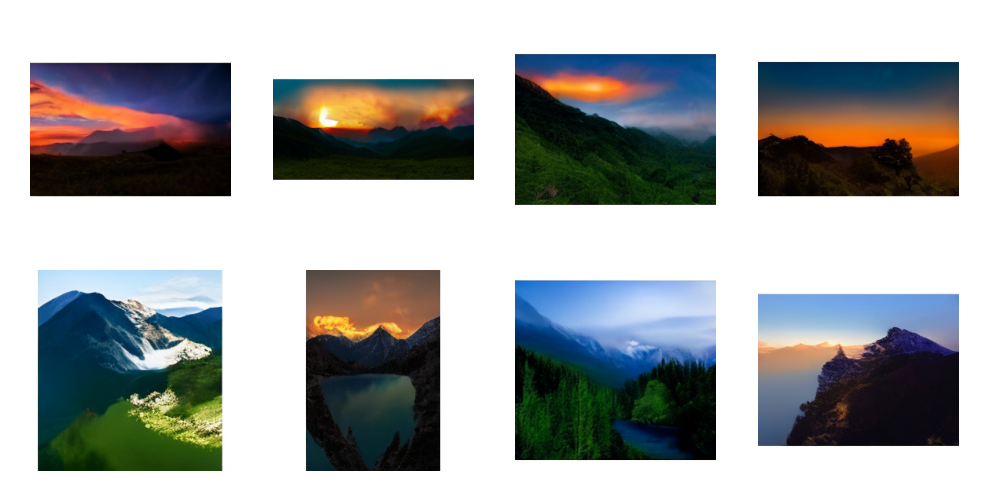

In [5]:
plotImages(generated, fig_size=(4, 4), dpi=300)